In [49]:
# ✅ End-to-End LangGraph Supervisor Example with Subtools (Notebook-Ready)

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph_supervisor import create_supervisor
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, List
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()
import os

In [50]:

# ✅ Shared schema for LangGraph state
class DataObject(TypedDict):
    messages: Annotated[List, add_messages]

memory = MemorySaver()

openai_key = os.getenv('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3, api_key=openai_key)

In [51]:

# =========================
# Step 1: Define Subtools
# =========================
@tool
def select_data(query: str) -> dict:
    """selects data from database
    
        Parameters:
        query (str): A SELECT query string.
    
    Returns:
        List[dict]: List of rows as dictionary
        """
    
    print(query)

    return {'data': 'rajpurohitabhi' }

@tool
def insert_data(data: str) -> str:
    """insert data into database"""
    return 'data was not inserted into database'

@tool
def credit_ops(webtop_id: str, process_id: str) -> str:
    """this is process named 'credit ops'.

    Parameters:
        webtop_id (str): webtop id is a number which is mixture of number and characters.
        process_id (str): an id starting with p following a number 
    
    Returns:
        List[dict]: string
    """
    return f"this is the data for the given webtop id and process - ' s- e- -f f-d'"

@tool
def reverse_text(text: str) -> str:
    """Reverses the given text."""
    return text[::-1]

@tool
def get_length(text: str) -> int:
    """Returns the length of the given text."""
    return len(text)


In [52]:


# ================================
# Step 2: Create Agents
# ================================

agent1 = create_react_agent(
    model=llm,
    tools=[select_data, insert_data],
    name="database_agent",
    prompt="select data from database or insert given data into database"
)

agent2 = create_react_agent(
    model=llm,
    tools=[credit_ops],
    name="underwriting_agent",
    prompt="""You specialize in all process that comes under underweiting like eg-'credit ops'.
    these process takes input  'webtop id', 'process id'"""
)

agent3 = create_react_agent(
    model=llm,
    tools=[reverse_text, get_length],
    name="text_utils_agent",
    prompt="You help with reversing and analyzing text."
)


In [ ]:

# ================================
# Step 3: Wrap Agents in Supervisor
# ================================
supervisor = create_supervisor(
    agents=[agent1, agent2, agent3],
    model=llm,
    prompt="""You are the main controller. Choose which agent should respond to the user query.

    use any agent if required to resolve user query.

    if user asks questions that dont meet any tool requirement
    then give user all names of available agent and ask which process he wants to run of those process names.

    if user asks to run any tool (database agent and its tools excluded) then ask user for webtopid  process name to run and task to run inside that process.

    if user asks about usage of a specific agent process then explain user about that process usage.

    webtop id and process name are mandatory after selecting a process agent, task name is optional.
    
    **IMPORTANT** :- always provide output from tools as response back to the user."""
).compile(checkpointer=memory)


In [58]:
config1 = { 'configurable': { 'thread_id': '1'} }

# ================================
# Step 4: Run Example Query
# ================================
query = {
    "messages": [
        {"role": "user", "content": "what was the output"}
    ]
}

result = supervisor.invoke(query, config=config1)
print("\n\U0001F4AC Final Response:")
print(result['messages'][-1].content)



💬 Final Response:
The output for the given webtop ID "3434f4ff9" and process ID "p200" was: **'s- e- -f f-d'**. 

If you have any further questions or need additional assistance, feel free to ask!


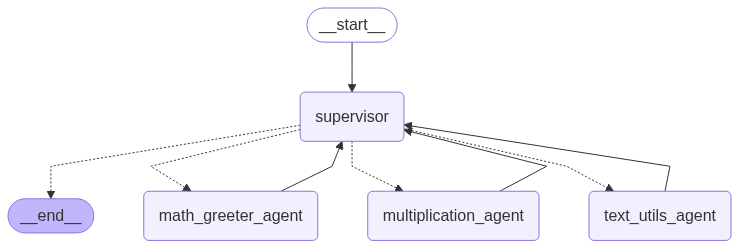

In [20]:


# ================================
# Step 5: Visualize Graph (Optional in Notebook)
# ================================
from IPython.display import Image, display
display(Image(supervisor.get_graph().draw_mermaid_png()))
